In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

In [2]:
from cpymad.madx import Madx

import pysixtracklib as pyst
from pysixtracklib import stcommon as st

In [3]:
from scipy.constants import e, m_p, c, epsilon_0

In [4]:
import sys, os
sys.path = ["/home/HPC/oeftiger/PyHEADTAIL_py3/python3/PyHEADTAIL/", 
            "/home/HPC/oeftiger/PyHEADTAIL_py3/"] + sys.path

import pickle

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [6]:
from pycuda.autoinit import context
from pycuda import gpuarray as gp

from pycuda.driver import memcpy_dtod_async

In [7]:
from PyHEADTAIL.general.element import Element
from PyHEADTAIL.general import pmath as pm
from PyHEADTAIL.particles.generators import (
    generate_Gaussian6DTwiss, cut_distribution, make_is_accepted_within_n_sigma)

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.spacecharge.pypic_factory import create_3dmesh_from_beam, create_mesh
from PyHEADTAIL.spacecharge.pypic_spacecharge import (
    SpaceChargePIC, SpaceChargePIC_Adaptive25D)

from PyHEADTAIL.general.contextmanager import GPU

from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.13.5


PyPIC v2.4.1
Info: cusolver_Rf not found. GPU finite difference solver not available.


In [8]:
from PyPIC.GPU.poisson_solver.FFT_solver import (
    GPUFFTPoissonSolver_2_5D, GPUFFTPoissonSolver)
from PyPIC.GPU.pypic import PyPIC_GPU

# not necessary but nice: memory pool sharing between PyHEADTAIL and PyPIC
try:
    from PyHEADTAIL.gpu.gpu_utils import memory_pool
except:
    memory_pool = None

In [9]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', 'np.asscalar')

### Note by Ingo:

In a first step we have explored the self-consistent "diffusion into resonance" of particles in a coasting beam in a straight (fully linear and symmetrical) FODO lattice, where koxy=92, and kxy=79.6 (equivalent KV value) deg. A Gaussian cut at 3.4 sigma is chosen.

The point is that this choice of WP allows particles in the Gaussian tails to to get caught by the 90 degree 4th order "incoherent resonance" driven by the space charge "octupole". They circle around the fixed points (at increased amplitudes) and thus weaken the core density. Thus, more particles gain a slightly higher betatron tune, and the process leads to an ongoing shift of particles to the resonance condition as is shown in the attached tune spectrum up to 1000 cells. The rms emittance plot up to 5000 cells indicates an ongoing process which sweeps particles from below 90 degrees to around 90 degrees. Eventually the beam core becomes deteriorated as shown on the density plot (x vs. cells). The 4th plot indicates the 99.99% emittance (halo size) - which saturates.  Olivers 2d Pyorbit results appear to confirm my Tracewin results shown below.

Would you be interested to try this in a model of a long bunch by a 2.5 d slice model, and comparing  it with a fully 3d simulation with Impact. Choosing a synchtrotron period between 100-1000 betatron periods would be interesting (long. Gaussian). 

In [10]:
n_macroparticles = int(1e6)
n_slices_sc = 64
n_sc_nodes = 10

# fixed field map for space charge
n_mesh_nodes = 256 #512
n_mesh_sigma = 24 #24

intensity = 8.846e9
epsn_x = 1e-6 # in [m.rad]
epsn_y = 1e-6 # in [m.rad]
epsg_z = 3.13e-05 # in [eV.s]
sigma_tau = 6.3e-10 # in [s]
# sigma_dp = 1e-15
# rf_voltage = 1e4
Qs = 9.2/360. #1e-2

# p0c = 100e6 # in eV

Ekin = 10e6 # in eV

circumference = 1
Qx = 92./360
Qy = Qx

###

p0c = np.sqrt(Ekin**2 + 2*Ekin*m_p/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (m_p/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e
gamma = np.sqrt(1 + (p0 / (m_p * c))**2)
beta = np.sqrt(1 - gamma**-2)
epsg_x = epsn_x / (beta * gamma)
epsg_y = epsn_y / (beta * gamma)
epsn_z = epsg_z / (beta * gamma)
bunch_length = 4 * sigma_tau
sigma_z = beta * c * bunch_length / 4. # in [m]

eta = -gamma**-2
# Qs = np.sqrt(e * rf_voltage * 1 * -eta / (2 * np.pi * p0 * beta * c))
rf_voltage = 2 * np.pi * p0 * beta * c * Qs**2 / (e * 1 * -eta)
beta_z = np.abs(eta) * circumference / (2 * np.pi * Qs)

# beta_z = sigma_z / sigma_dp
sigma_dp = sigma_z / beta_z
# epsn_z = sigma_z * sigma_dp * 4 * np.pi * p0 / e # sigma_z**2 * 4 * np.pi * p0 / (e * beta_z)

In [11]:
def provide_pycuda_array(ptr):
    return gp.GPUArray(n_macroparticles, dtype=np.float64, gpudata=ptr)

# Set up FODO cell in MAD-X

In [12]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.07.19 11:00:00      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [13]:
madx.input('''
kqd := -14.17 * 0.1;
kqf := 14.17 * 0.1;
v := 0;

qd: multipole, knl := {0, kqd/2.};
qf: multipole, knl := {0, kqf};
rf: rfcavity, volt := v, harmon = 1, lag = 0; //, lag = 0.5;
'''
+
'''
fodo: sequence, l = {0};
qd, at = 0;
rf, at = {0} / 4.;
qf, at = {0} / 2.;
rf, at = {0} * 3 / 4.;
qd, at = {0};
endsequence;
'''.format(circumference))

True

In [14]:
madx.command.beam(particle='proton', energy=str(Etot)) # energy in GeV

True

In [15]:
madx.use(sequence='fodo')

In [16]:
madx.input(
'''match, sequence=fodo;
global, sequence=fodo, q1={Qx}, q2={Qy};
vary, name = kqd, step=0.0001;
vary, name = kqf, step=0.0001;
lmdif, tolerance=1e-20;
endmatch;
'''.format(Qx=Qx, Qy=Qy))

START MATCHING

number of sequences: 1
sequence name: fodo
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:

Initial Penalty Function =   0.39363548E+01


call:       4   Penalty function =   0.48565936E-02
call:       7   Penalty function =   0.30584034E-06
call:      10   Penalty function =   0.12459341E-14
call:      13   Penalty function =   0.31338732E-25
 ++++++++++ LMDIF ended: converged successfully
call:      13   Penalty function =   0.31338732E-25

MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------
Global constraint:         q1           4     2.55555556E-01     2.55555556E-01     1.77493704E-26
Global constraint:         q2           4     2.55555556E-01     2.55555556E-01     1.35893617E-26


Final Penalty Function =   3.13387321e-26





Variable                 Final Value  In

True

# Add space charge placeholders

In [17]:
madx.input('sc_placeholder: Marker;')

True

In [18]:
madx.command.seqedit(sequence='FODO')
for s_sc in np.linspace(start=0, stop=circumference, num=n_sc_nodes, endpoint=False):
    madx.command.install(element='sc_placeholder', at=s_sc)
madx.command.flatten()
madx.command.endedit()

++++++ info: seqedit - number of elements installed:  10
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [19]:
madx.use(sequence='fodo')

In [20]:
twiss = madx.twiss()
assert circumference == twiss['s'][-1]

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                 1                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.2555555556       -2.275686413        1.720387814                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.2555555556 

               dq2            betymax              dymax              dyrms 
      -2.275686413        1.720387814                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

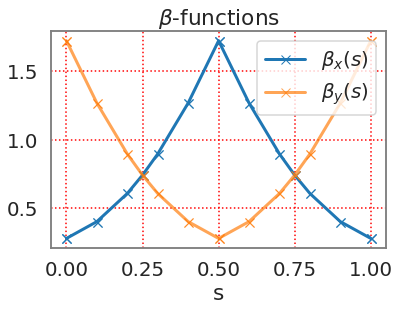

In [21]:
plt.title(r'$\beta$-functions')
plt.plot(twiss['s'], twiss['betx'], marker='x', label=r'$\beta_x(s)$')
plt.plot(twiss['s'], twiss['bety'], marker='x', label=r'$\beta_y(s)$', alpha=0.7)
plt.xlabel('s')
plt.legend();

# switch on synchrotron motion

In [22]:
madx.input('v := {}'.format(0.5 * rf_voltage * 1e-6)) # MV --> 0.5x because there are 2 cavities

++++++ info: v redefined


True

# Preparing PyHEADTAIL beam

In [23]:
D_x_0 = twiss['dx'][0] * beta
D_y_0 = twiss['dy'][0] * beta

np.random.seed(0)

pyht_beam = generate_Gaussian6DTwiss(
    n_macroparticles, intensity, e, m_p, circumference, gamma,
    twiss['alfx'][0], twiss['alfy'][0], twiss['betx'][0], twiss['bety'][0],
    beta_z, epsn_x, epsn_y, epsn_z,
    dispersion_x=D_x_0 if D_x_0 else None,
    dispersion_y=D_y_0 if D_y_0 else None,
    limit_n_rms_x=3.4**2, limit_n_rms_y=3.4**2, limit_n_rms_z=3.4**2,
)

In [24]:
from PyHEADTAIL.particles import generators

In [25]:
distribution_z_uncut = generators.gaussian2D(
    sigma_z**2)

is_accepted = generators.make_is_accepted_within_n_sigma(
    epsn_rms=sigma_z,
    limit_n_rms=3.4,
)
distribution_z_cut = generators.cut_distribution(distribution_z_uncut, is_accepted)

In [26]:
z, dp = distribution_z_cut(n_macroparticles)

pyht_beam.z, pyht_beam.dp = z, dp / beta_z

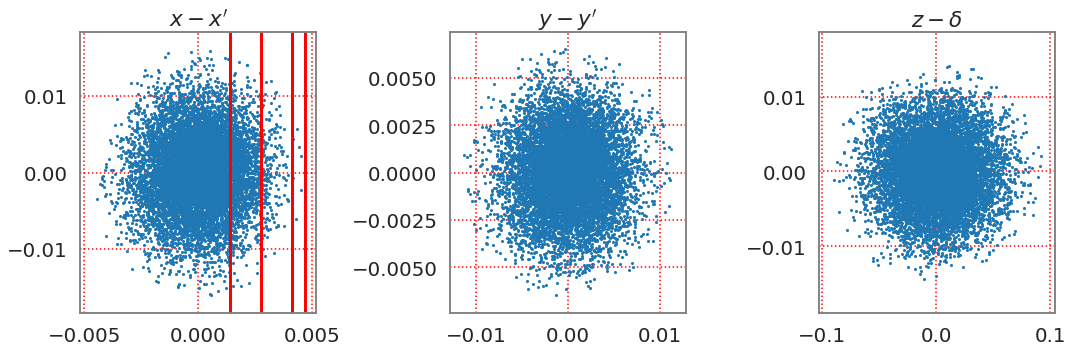

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.sca(ax[0])
plt.title('$x-x\'$')
plt.scatter(pyht_beam.x[::100], pyht_beam.xp[::100], s=10, marker='.')
plt.xlim(1.1*pyht_beam.x.min(), 1.1*pyht_beam.x.max())
plt.ylim(1.1*pyht_beam.xp.min(), 1.1*pyht_beam.xp.max())
plt.axvline(pyht_beam.sigma_x(), color='red')
plt.axvline(2*pyht_beam.sigma_x(), color='red')
plt.axvline(3*pyht_beam.sigma_x(), color='red')
plt.axvline(3.4*pyht_beam.sigma_x(), color='red')

plt.sca(ax[1])
plt.title('$y-y\'$')
plt.scatter(pyht_beam.y[::100], pyht_beam.yp[::100], s=10, marker='.')
plt.xlim(1.1*pyht_beam.y.min(), 1.1*pyht_beam.y.max())
plt.ylim(1.1*pyht_beam.yp.min(), 1.1*pyht_beam.yp.max())

plt.sca(ax[2])
plt.title('$z-\delta$')
plt.scatter(pyht_beam.z[::100], pyht_beam.dp[::100], s=10, marker='.')
plt.tight_layout()

In [28]:
rf_voltage

83385.94872061806

In [29]:
Qs

0.025555555555555554

In [30]:
0.496e5 / (Etot * 1e9) / beta**2

0.002493145729894359

In [31]:
pyht_beam.sigma_dp()

0.004443514432254605

In [32]:
pyht_beam.epsn_z()

0.0006942087676131392

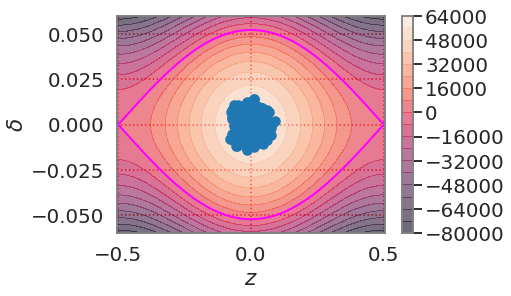

In [33]:
rfb = RFBucket(circumference, gamma, m_p, e, [0], 0, [1], [rf_voltage], [np.pi])

z = np.linspace(*rfb.interval, num=100)
dp = np.linspace(-0.06, 0.06, num=100)
ZZ, DPP = np.meshgrid(z, dp)
HH = rfb.hamiltonian(ZZ, DPP, make_convex=True)
plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
plt.colorbar()
plt.contour(ZZ, DPP, HH, levels=[0], colors='magenta', linewidths=2)
plt.scatter(pyht_beam.z[::1000], pyht_beam.dp[::1000])
plt.xlabel(r'$z$')
plt.ylabel(r'$\delta$');

In [34]:
from PyHEADTAIL.spacecharge.spacecharge import LongSpaceCharge

In [35]:
slicer_long_sc = UniformBinSlicer(n_slices=1000, z_cuts=rfb.interval)

In [36]:
long_sc = LongSpaceCharge(slicer=slicer_long_sc, pipe_radius=10e-2, length=circumference, n_slice_sigma=5)

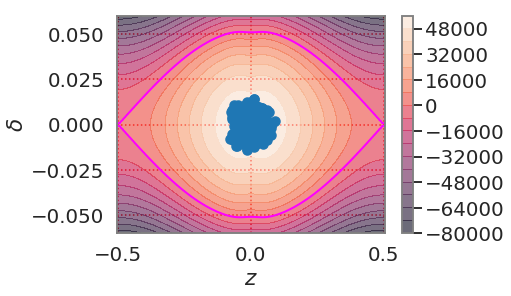

In [37]:
rfb = RFBucket(circumference, gamma, m_p, e, [0], 0, [1], [rf_voltage], [np.pi])
rfb.add_fields([long_sc.make_force(pyht_beam)], [long_sc.make_potential(pyht_beam)])

z = np.linspace(*rfb.interval, num=100)
dp = np.linspace(-0.06, 0.06, num=100)
ZZ, DPP = np.meshgrid(z, dp)
HH = rfb.hamiltonian(ZZ, DPP, make_convex=True)
plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
plt.colorbar()
plt.contour(ZZ, DPP, HH, levels=[0], colors='magenta', linewidths=2)
plt.scatter(pyht_beam.z[::1000], pyht_beam.dp[::1000])
plt.xlabel(r'$z$')
plt.ylabel(r'$\delta$');

In [38]:
lmbda = intensity * e / (np.sqrt(2*np.pi) * sigma_z) * 0.682689 # 1 RMS
Ksc = e / (pyht_beam.gamma**3 * m_p * (pyht_beam.beta * c)**2) * lmbda / (2*np.pi*epsilon_0)
R = circumference / (2*np.pi)

def dQ_inc(thissize, theothersize, thistune, Ksc=Ksc):
    'incoherent KV tune shift'
    return Ksc * R**2 / (4 * thistune * thissize * (thissize+theothersize))

print ('dQ_x = {0:.3f} and dQ_y = {1:.3f}'.format(
    dQ_inc(pyht_beam.sigma_x(), pyht_beam.sigma_y(), Qx), 
    dQ_inc(pyht_beam.sigma_y(), pyht_beam.sigma_x(), Qy)))

dQ_x = 0.047 and dQ_y = 0.019


We want 79.6deg of SC suppressed cell phase advance:

In [39]:
(Qx - dQ_inc(np.sqrt(epsg_x * R / Qx), 
             np.sqrt(epsg_y * R / Qy), Qx)) * 360.

78.91436179874681

# Preparing PySTL for GPU

In [40]:
pyst_beam = pyst.Particles.from_ref(num_particles=n_macroparticles, p0c=p0c)

In [41]:
elements = pyst.Elements.from_mad(madx.sequence.FODO, exact_drift=True)

In [42]:
idx_mad_sc = [i for i, name in enumerate(madx.sequence.FODO.element_names()) 
              if 'sc_placeholder' in name]
sc_optics = {
    'beta_x': twiss['betx'][idx_mad_sc],
    'beta_y': twiss['bety'][idx_mad_sc],
    'D_x': twiss['dx'][idx_mad_sc],
    'D_y': twiss['dy'][idx_mad_sc],
    'x': twiss['x'][idx_mad_sc],
    'y': twiss['y'][idx_mad_sc],
    's': twiss['s'][idx_mad_sc]
}

In [43]:
trackjob = pyst.CudaTrackJob(elements, pyst_beam)

# Interface to PyHEADTAIL

In [44]:
from pycuda import cumath

In [45]:
class TrackSixTrackLib(Element):
    '''General state.'''
    trackjob = None
    pointers = {}
    context = None
    n_elements = 0

    def __init__(self, trackjob, i_start, i_end, context=context):
        if TrackSixTrackLib.trackjob is None:
            TrackSixTrackLib.trackjob = trackjob

            trackjob.fetch_particle_addresses()
            assert trackjob.last_status_success
            ptr = trackjob.get_particle_addresses() # particleset==0 is default

            TrackSixTrackLib.pointers.update({
                'x': provide_pycuda_array(ptr.contents.x),
                'px': provide_pycuda_array(ptr.contents.px),
                'y': provide_pycuda_array(ptr.contents.y),
                'py': provide_pycuda_array(ptr.contents.py),
                'z': provide_pycuda_array(ptr.contents.zeta),
                'delta': provide_pycuda_array(ptr.contents.delta),
                'rpp': provide_pycuda_array(ptr.contents.rpp),
                'psigma': provide_pycuda_array(ptr.contents.psigma),
                'rvv': provide_pycuda_array(ptr.contents.rvv),
            })
            TrackSixTrackLib.n_elements = len(trackjob.beam_elements_buffer.get_elements())

        self.i_start = i_start
        self.i_end = i_end
        self.is_last_element = (i_end == self.n_elements)

        self.context = context

    def track(self, beam):
        # pass arrays and convert units
        self.pyht_to_stlib(beam)
        # track in SixTrackLib
        trackjob.track_line(self.i_start, self.i_end, 
                            finish_turn=self.is_last_element)
        # to be replaced by barrier:
        trackjob.collectParticlesAddresses()

        assert trackjob.last_track_status_success
        # pass arrays back (converting units back)
        self.stlib_to_pyht(beam)

    def pyht_to_stlib(self, beam):
        self.memcpy(self.pointers['x'], beam.x)
        self.memcpy(self.pointers['px'], beam.xp)
        self.memcpy(self.pointers['y'], beam.y)
        self.memcpy(self.pointers['py'], beam.yp)
        self.memcpy(self.pointers['z'], beam.z)
        self.memcpy(self.pointers['delta'], beam.dp)
        
        # further longitudinal coordinates of SixTrackLib
        rpp = 1. / (beam.dp + 1)
        self.memcpy(self.pointers['rpp'], rpp)

        restmass = beam.mass * c**2
        restmass_sq = restmass**2
        E0 = np.sqrt((beam.p0 * c)**2 + restmass_sq)
        p = beam.p0 * (1 + beam.dp)
        E = cumath.sqrt((p * c) * (p * c) + restmass_sq)
        psigma =  (E - E0) / (beam.beta * beam.p0 * c)
        self.memcpy(self.pointers['psigma'], psigma)
                    
        gamma = E / restmass
        beta = cumath.sqrt(1 - 1. / (gamma * gamma))
        rvv = beta / beam.beta
        self.memcpy(self.pointers['rvv'], rvv)
        
        self.context.synchronize()

    @staticmethod
    def memcpy(dest, src):
        '''device memory copy with pycuda from src GPUArray to dest GPUArray.'''
#         dest[:] = src
#         memcpy_atoa(dest, 0, src, 0, len(src))
        memcpy_dtod_async(dest.gpudata, src.gpudata, src.nbytes)

    def stlib_to_pyht(self, beam):
        beam.x = self.pointers['x']
        beam.xp = self.pointers['px']
        beam.y = self.pointers['y']
        beam.yp = self.pointers['py']
        beam.z = self.pointers['z']
        beam.dp = self.pointers['delta']

# Prepare PyHEADTAIL style one-turn map

In [46]:
def rms_beam_size(beta_optics, epsn, disp_optics, 
                  sigma_dp=pyht_beam.sigma_dp(), beta=beta, gamma=gamma):
    return np.sqrt(beta_optics * epsn / (beta * gamma) + (disp_optics * sigma_dp)**2)

In [47]:
sig_x = rms_beam_size(sc_optics['beta_x'], epsn_x, sc_optics['D_x']).max()
sig_y = rms_beam_size(sc_optics['beta_y'], epsn_y, sc_optics['D_y']).max()

In [48]:
print ('The smallest horizontal beam size is {:.2f}% smaller than the largest beam size.'.format(
    (sig_x - rms_beam_size(sc_optics['beta_x'], epsn_x, sc_optics['D_x']).min()) / sig_x * 100))

print ('The smallest vertical beam size is {:.2f}% smaller than the largest beam size.'.format(
    (sig_y - rms_beam_size(sc_optics['beta_y'], epsn_y, sc_optics['D_y']).min()) / sig_y * 100))

The smallest horizontal beam size is 59.60% smaller than the largest beam size.
The smallest vertical beam size is 59.60% smaller than the largest beam size.


In [49]:
slicer_sc = UniformBinSlicer(n_slices_sc, n_sigma_z=4) #z_cuts=slicing_interval)

In [50]:
slices = pyht_beam.get_slices(slicer_sc)
assert not any(slices.particles_outside_cuts)

Use the maximum size needed for the transverse grid:

In [51]:
# mesh_3d = create_3dmesh_from_beam(pyht_beam, [n_mesh_nodes]*2, [n_mesh_sigma]*2, 
#                                   slices=pyht_beam.get_slices(slicer_sc))

mesh_origin = [-n_mesh_sigma * sig_x, 
               -n_mesh_sigma * sig_y]
mesh_distances = [2 * n_mesh_sigma * sig_x / n_mesh_nodes, 
                  2 * n_mesh_sigma * sig_y / n_mesh_nodes]
mesh_3d = create_mesh(mesh_origin, mesh_distances, [n_mesh_nodes]*2, slices=slices)

In [52]:
# poissonsolver = GPUFFTPoissonSolver_2_5D(mesh_3d, context=context, save_memory=False)
poissonsolver = GPUFFTPoissonSolver(mesh_3d, context=context)
pypic_algorithm = PyPIC_GPU(mesh_3d, poissonsolver, context=context, 
                            memory_pool=memory_pool)

In [53]:
sum(el.length for el in elements.get_elements() if isinstance(el, pyst.DriftExact))

1.0

In [54]:
one_turn_map = []

relevant_elements = elements.get_elements()

if isinstance(elements.get_elements()[-1], pyst.BeamMonitor):
    relevant_elements = relevant_elements[:-1]

i_last = 0
length_covered = 0
for i_curr, el in enumerate(relevant_elements):
    if not isinstance(el, pyst.DriftExact):
        continue
    length_covered += el.length

    #i_curr == 0 or 
    if el.length != 0 : # only inject SC node at markers (for SC)
        continue

    pyst_node = TrackSixTrackLib(trackjob, i_last, i_curr + 1, context=context)
    one_turn_map.append(pyst_node)

    sc_node = SpaceChargePIC(length_covered, pypic_algorithm)
    one_turn_map.append(sc_node)

    i_last = i_curr
    length_covered = 0

assert pyst_node.i_end == len(relevant_elements)
assert el._offset == relevant_elements[-1]._offset
assert isinstance(el, pyst.DriftExact)
assert el.length == 0

pyst_node.is_last_element = True

# Tracking space charge and full optics:

In [55]:
def get_action(u, up, dp=None, alpha_twiss=0, beta_twiss=1, disp=0):
    if disp and dp.any():
        u = u - disp * dp
    gamma_twiss = (1 + alpha_twiss**2) / beta_twiss
    J = 0.5 * (gamma_twiss * u**2 + 2*alpha_twiss * u * up + beta_twiss * up**2)
    return J

In [56]:
n_turns = 5000 #128 - 1 #

# coherent centroid evolution
rec_mean_x = np.empty(n_turns + 1, dtype=float)
rec_mean_y = np.empty_like(rec_mean_x)

rec_mean_x[0] = pyht_beam.mean_x()
rec_mean_y[0] = pyht_beam.mean_y()

# RMS emittance evolution
rec_epsn_x = np.empty(n_turns + 1, dtype=float)
rec_epsn_y = np.empty_like(rec_epsn_x)

rec_epsn_x[0] = pyht_beam.epsn_x()
rec_epsn_y[0] = pyht_beam.epsn_y()

# 100% emittance evolution
rec_epsn100_x = np.empty(n_turns + 1, dtype=float)
rec_epsn100_y = np.empty_like(rec_epsn100_x)

rec_epsn100_x[0] = beta * gamma * get_action(
    pyht_beam.x, pyht_beam.xp, pyht_beam.dp, 
    twiss['alfx'][0], twiss['betx'][0], D_x_0).max()
rec_epsn100_y[0] = beta * gamma * get_action(
    pyht_beam.y, pyht_beam.yp, pyht_beam.dp, 
    twiss['alfy'][0], twiss['bety'][0], D_y_0).max()

# incoherent (1000 particles) motion
rec_inc_x = np.empty((n_turns+1, 1000), dtype=float)
rec_inc_xp = np.empty_like(rec_inc_x)
rec_inc_y = np.empty_like(rec_inc_x)
rec_inc_yp = np.empty_like(rec_inc_x)
rec_inc_z = np.empty_like(rec_inc_x)
rec_inc_dp = np.empty_like(rec_inc_x)

pyht_beam.sort_for('id')
rec_inc_x[0, :] = pyht_beam.x[:1000]
rec_inc_xp[0, :] = pyht_beam.xp[:1000]
rec_inc_y[0, :] = pyht_beam.y[:1000]
rec_inc_yp[0, :] = pyht_beam.yp[:1000]
rec_inc_z[0, :] = pyht_beam.z[:1000]
rec_inc_dp[0, :] = pyht_beam.dp[:1000]

with GPU(pyht_beam):
    for i in range(1, n_turns+1):
        for m in one_turn_map:
            m.track(pyht_beam)

        rec_mean_x[i] = pyht_beam.mean_x().get()
        rec_mean_y[i] = pyht_beam.mean_y().get()

        rec_epsn_x[i] = pyht_beam.epsn_x().get()
        rec_epsn_y[i] = pyht_beam.epsn_y().get()

        rec_epsn100_x[i] = beta * gamma * pm.max(get_action(
            pyht_beam.x, pyht_beam.xp, pyht_beam.dp, 
            twiss['alfx'][0], twiss['betx'][0], D_x_0))
        rec_epsn100_y[i] = beta * gamma * pm.max(get_action(
            pyht_beam.y, pyht_beam.yp, pyht_beam.dp, 
            twiss['alfy'][0], twiss['bety'][0], D_y_0))
        
        pyht_beam.sort_for('id')
        rec_inc_x[i, :] = pyht_beam.x[:1000].get()
        rec_inc_xp[i, :] = pyht_beam.xp[:1000].get()
        rec_inc_y[i, :] = pyht_beam.y[:1000].get()
        rec_inc_yp[i, :] = pyht_beam.yp[:1000].get()
        rec_inc_z[i, :] = pyht_beam.z[:1000].get()
        rec_inc_dp[i, :] = pyht_beam.dp[:1000].get()

        sys.stdout.write('\rTurn {}/{}'.format(i, n_turns))

Turn 5000/5000

In [57]:
pickle.dump(pyht_beam, open('beam.p', 'wb'))

In [58]:
pyht_beam = pickle.load(open('beam.p', 'rb'))

In [59]:
np.save('syncmot3DPIC_1e6mp_results_epsnxy', np.vstack((rec_epsn_x, rec_epsn_y, rec_epsn100_x, rec_epsn100_y)))

np.save('syncmot3DPIC_1e6mp_results_meanxy', np.vstack((rec_mean_x, rec_mean_y)))

np.save('syncmot3DPIC_1e6mp_results_inc_x', rec_inc_x)
np.save('syncmot3DPIC_1e6mp_results_inc_y', rec_inc_y)

In [60]:
(rec_epsn_x, rec_epsn_y, rec_epsn100_x, rec_epsn100_y) = np.load('syncmot3DPIC_1e6mp_results_epsnxy.npy')

(rec_mean_x, rec_mean_y) = np.load('syncmot3DPIC_1e6mp_results_meanxy.npy')

rec_inc_x = np.load('syncmot3DPIC_1e6mp_results_inc_x.npy')
rec_inc_y = np.load('syncmot3DPIC_1e6mp_results_inc_y.npy')

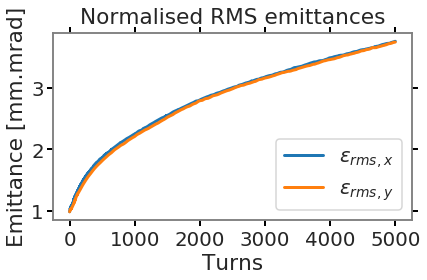

In [61]:
plt.plot(rec_epsn_x * 1e6, label=r'$\epsilon_{rms,x}$')
plt.plot(rec_epsn_y * 1e6, label=r'$\epsilon_{rms,y}$')
plt.legend()
plt.xlabel('Turns')
plt.ylabel('Emittance [mm.mrad]')
plt.title('Normalised RMS emittances', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_epsnxy.png', dpi=150, bbox_inches='tight')

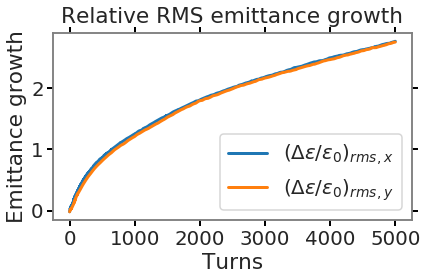

In [62]:
plt.plot((rec_epsn_x - epsn_x) / epsn_x, label=r'$(\Delta \epsilon/\epsilon_0)_{rms,x}$')
plt.plot((rec_epsn_y - epsn_y) / epsn_y, label=r'$(\Delta \epsilon/\epsilon_0)_{rms,y}$')
plt.legend()
plt.xlabel('Turns')
plt.ylabel('Emittance growth')
plt.title('Relative RMS emittance growth', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_epsnxy_rel.png', dpi=150, bbox_inches='tight')

In [63]:
sc_node.pypic.mesh.x0

-0.08227579236126242

In [64]:
pyht_beam.x.min()

-0.015587358861857093

In [65]:
sc_node.pypic.mesh.y0

-0.08227579236126313

In [66]:
pyht_beam.y.min()

-0.03538949370423711

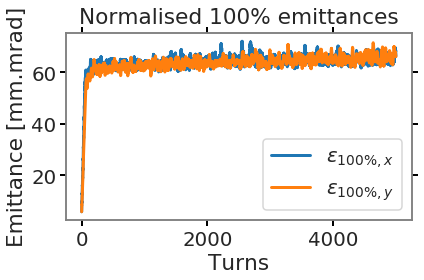

In [67]:
plt.plot(rec_epsn100_x * 1e6, label=r'$\epsilon_{100\%,x}$')
plt.plot(rec_epsn100_y * 1e6, label=r'$\epsilon_{100\%,y}$')
plt.legend()
plt.xlabel('Turns')
plt.ylabel('Emittance [mm.mrad]')
plt.title('Normalised 100% emittances', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_epsn100xy.png', dpi=150, bbox_inches='tight')

In [68]:
np.sqrt(rec_epsn100_y[0] * twiss['bety'][0])

0.003153362929406291

In [69]:
pyht_beam.sigma_x()

0.0027392167751596696

In [70]:
pyht_beam.sigma_y()

0.006702224242541461

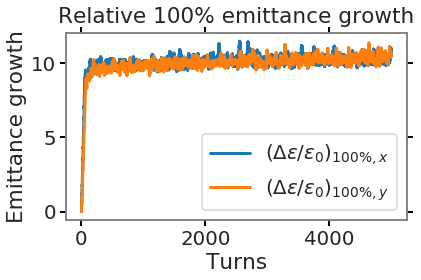

In [71]:
plt.plot((rec_epsn100_x - rec_epsn100_x[0]) / rec_epsn100_x[0],
         label=r'$(\Delta \epsilon/\epsilon_0)_{100\%,x}$')
plt.plot((rec_epsn100_y - rec_epsn100_y[0]) / rec_epsn100_y[0],
         label=r'$(\Delta \epsilon/\epsilon_0)_{100\%,y}$')
plt.legend()
plt.xlabel('Turns')
plt.ylabel('Emittance growth')
plt.title('Relative 100% emittance growth', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_epsn100xy_rel.png', dpi=150, bbox_inches='tight')

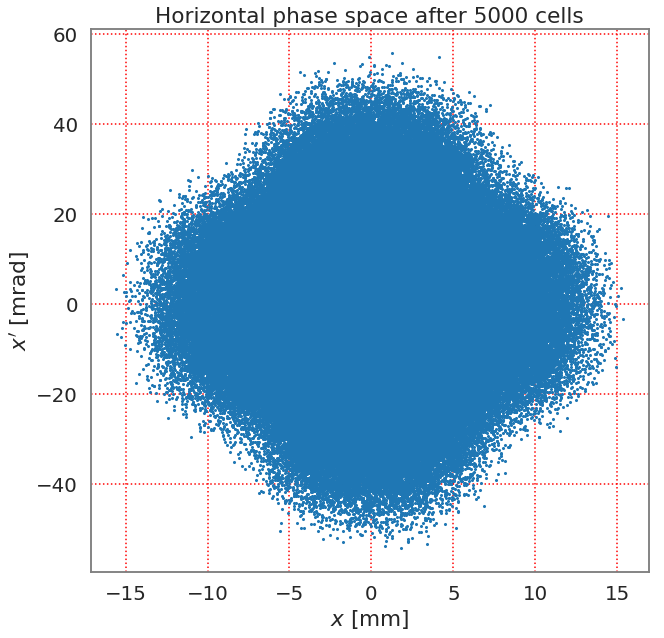

In [72]:
plt.figure(figsize=(10, 10))
plt.scatter(pyht_beam.x * 1e3, pyht_beam.xp * 1e3, marker='.', s=10)
plt.xlabel('$x$ [mm]')
plt.ylabel(r"$x'$ [mrad]")
plt.title('Horizontal phase space after 5000 cells')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_phasespace_x.png', dpi=150, bbox_inches='tight')

In [73]:
slices = pyht_beam.get_slices(slicer_sc)

peak_ids = slices.particle_indices_of_slice(slicer_sc.n_slices // 2)

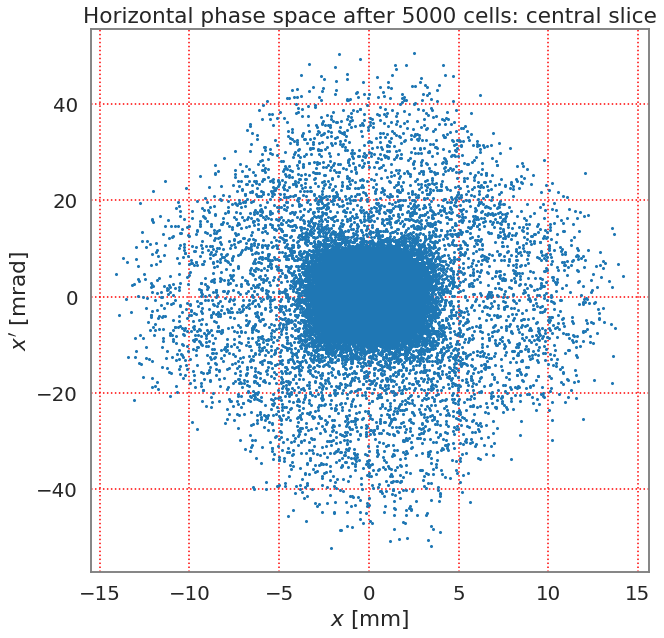

In [74]:
plt.figure(figsize=(10, 10))
plt.scatter(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, marker='.', s=10)
# plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100);
plt.xlabel('$x$ [mm]')
plt.ylabel(r"$x'$ [mrad]")
plt.title('Horizontal phase space after 5000 cells: central slice')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_phasespace_x_core.png', dpi=150, bbox_inches='tight')

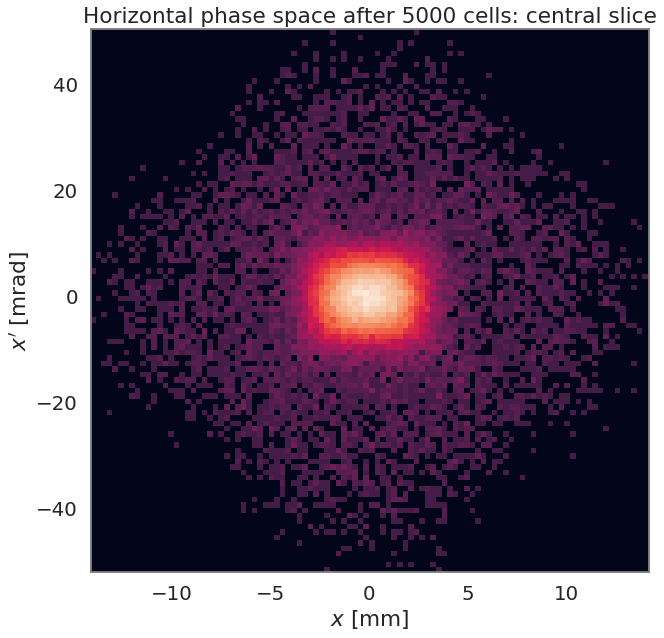

In [75]:
plt.figure(figsize=(10, 10))
plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100, norm=mcolors.PowerNorm(0.3))
# plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100);
plt.xlabel('$x$ [mm]')
plt.ylabel(r"$x'$ [mrad]")
plt.title('Horizontal phase space after 5000 cells: central slice')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_phasespace_x_core_hist.png', dpi=150, bbox_inches='tight')

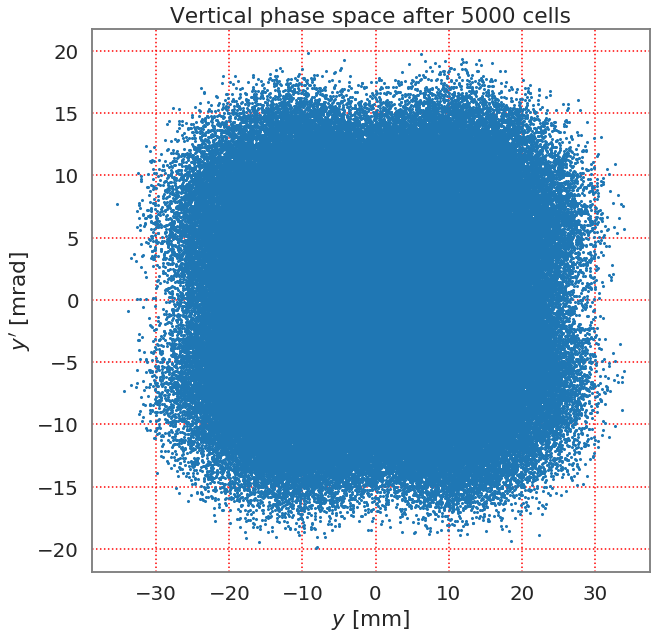

In [76]:
plt.figure(figsize=(10, 10))
plt.scatter(pyht_beam.y * 1e3, pyht_beam.yp * 1e3, marker='.', s=10)
plt.xlabel('$y$ [mm]')
plt.ylabel(r"$y'$ [mrad]")
plt.title('Vertical phase space after 5000 cells')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_phasespace_y.png', dpi=150, bbox_inches='tight')

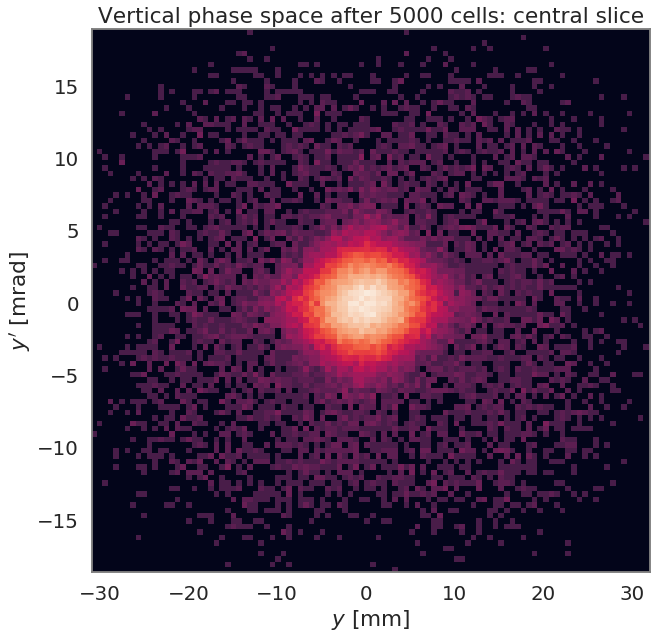

In [77]:
plt.figure(figsize=(10, 10))
plt.hist2d(pyht_beam.y[peak_ids] * 1e3, pyht_beam.yp[peak_ids] * 1e3, bins=100, norm=mcolors.PowerNorm(0.3))
# plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100);
plt.xlabel('$y$ [mm]')
plt.ylabel(r"$y'$ [mrad]")
plt.title('Vertical phase space after 5000 cells: central slice')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_phasespace_y_core_hist.png', dpi=150, bbox_inches='tight')

In [78]:
alpha_x = twiss['alfx'][0]
beta_x = twiss['betx'][0]

maximum $x$ amplitude of recorded particles:

In [79]:
np.sqrt(get_action(rec_inc_x[-1], rec_inc_xp[-1], alpha_twiss=alpha_x, beta_twiss=beta_x).max() * 2 * beta_x)

0.014091948540212012

In [80]:
id_max = np.argmax(get_action(rec_inc_x[-1], rec_inc_xp[-1], alpha_twiss=alpha_x, beta_twiss=beta_x))

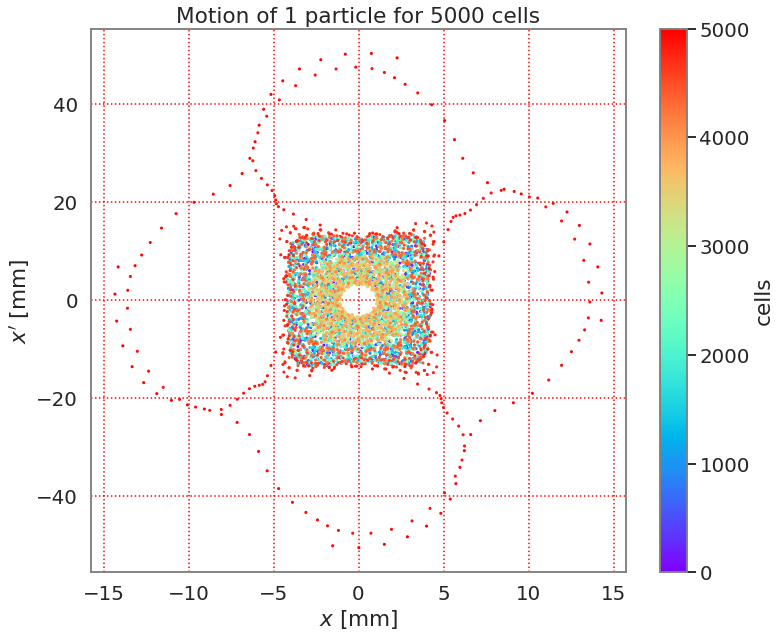

In [81]:
plt.figure(figsize=(12, 10))
plt.scatter(rec_inc_x[:, id_max] * 1e3, rec_inc_xp[:, id_max] * 1e3, marker='.', 
            s=10, c=np.arange(len(rec_inc_x[:, id_max])), cmap=plt.get_cmap('rainbow'))
cbar = plt.colorbar()
cbar.set_label('cells')
# plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100);
plt.xlabel('$x$ [mm]')
plt.ylabel(r"$x'$ [mm]")
plt.title('Motion of 1 particle for 5000 cells')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_particlemotion.png', dpi=150, bbox_inches='tight')

In [82]:
id_interm = np.argsort(-get_action(rec_inc_x[-1], rec_inc_xp[-1], alpha_twiss=alpha_x, beta_twiss=beta_x))[100]

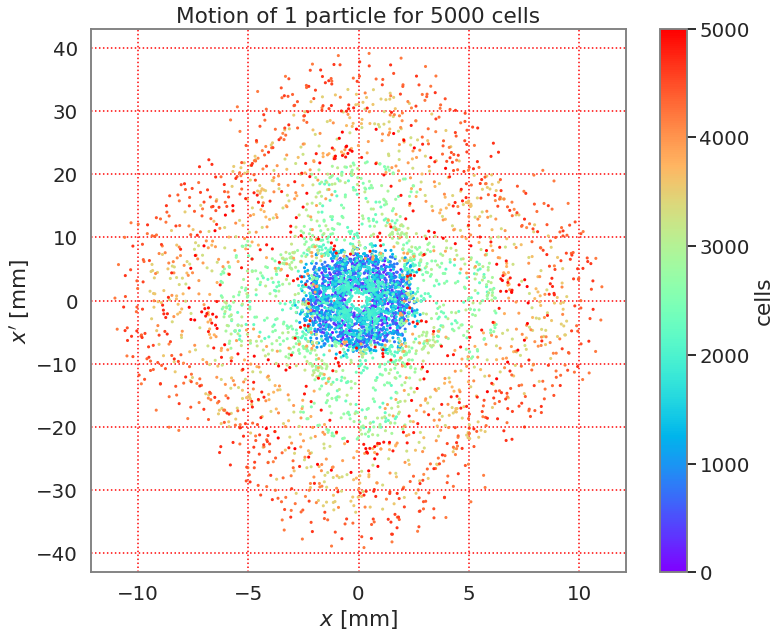

In [83]:
plt.figure(figsize=(12, 10))
plt.scatter(rec_inc_x[:, id_interm] * 1e3, rec_inc_xp[:, id_interm] * 1e3, marker='.', 
            s=10, c=np.arange(len(rec_inc_x[:, id_interm])), cmap=plt.get_cmap('rainbow'))
cbar = plt.colorbar()
cbar.set_label('cells')
# plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100);
plt.xlabel('$x$ [mm]')
plt.ylabel(r"$x'$ [mm]")
plt.title('Motion of 1 particle for 5000 cells')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_particlemotion_interm.png', dpi=150, bbox_inches='tight')

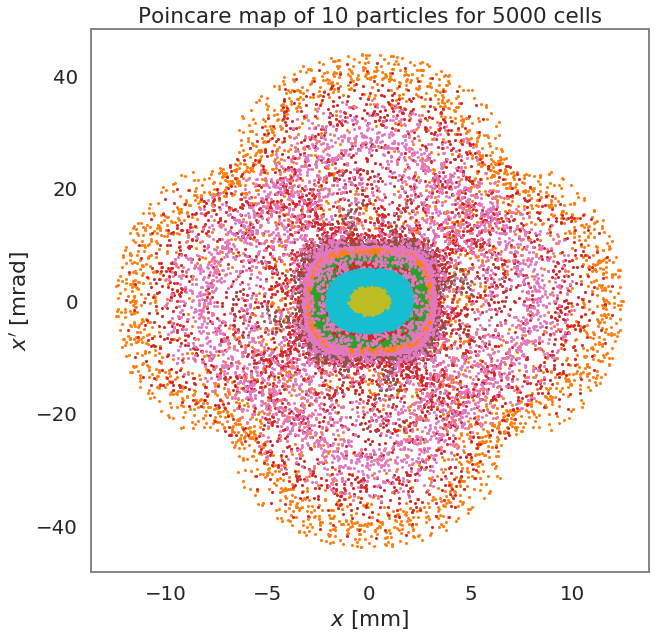

In [84]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.scatter(rec_inc_x[:, i] * 1e3, rec_inc_xp[:, i] * 1e3, marker='.', s=10)
# plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100);
plt.grid(False)

# plt.axvline(mesh_3d.x0 * 1e3, color='black', ls=':')
# plt.axhline(mesh_3d.y0 * 1e3, color='black', ls=':')
# plt.axvline(-mesh_3d.x0 * 1e3, color='black', ls=':')
# plt.axhline(-mesh_3d.y0 * 1e3, color='black', ls=':')

plt.xlabel('$x$ [mm]')
plt.ylabel(r"$x'$ [mrad]")
plt.title('Poincare map of 10 particles for 5000 cells')
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_poincaremap_x.png', dpi=150, bbox_inches='tight')

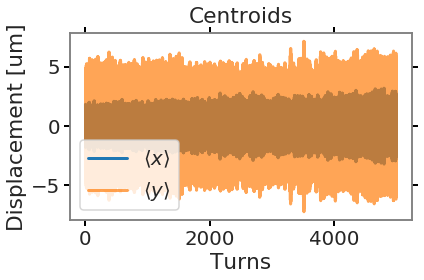

In [85]:
plt.plot(rec_mean_x * 1e6, label=r'$\langle x \rangle$')
plt.plot(rec_mean_y * 1e6, label=r'$\langle y \rangle$', alpha=0.7)
plt.legend()
plt.xlabel('Turns')
plt.ylabel('Displacement [um]')
plt.title('Centroids', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_centroids.png', dpi=150, bbox_inches='tight')

In [103]:
class State(object):
    pass
state = State()

In [104]:
with GPU(pyht_beam):
    pyht_beam.sort_for('id')
    xp0 = pyht_beam.xp.copy()
    sc_node.track(pyht_beam, state)
    pyht_beam.sort_for('id')
    xp1 = pyht_beam.xp.copy()
    pyht_beam.xp = xp0.copy()

In [105]:
with GPU(pyht_beam):
    out = sc_node.pypic.particles_to_mesh(pyht_beam.x, pyht_beam.y, pyht_beam.z_beamframe)

In [106]:
gp.sum(xp1 - xp0)

array(7.80625564e-14)

In [107]:
pyht_beam.z[0]

-0.00956680793370536

In [108]:
pyht_beam.x[0]

6.952877611725739e-05

In [109]:
pyht_beam.y[0]

0.0007525905693695877

In [110]:
(xp1 - xp0).get()[0]

9.020099995306514e-06

In [111]:
mesh_3d.z0

-0.10966791687649688

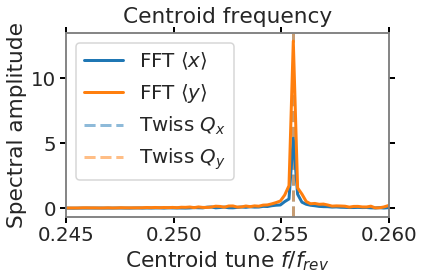

In [89]:
current_palette = sns.color_palette()
plt.plot(np.fft.rfftfreq(n_turns+1), np.abs(np.fft.rfft(rec_mean_x)) * 1e3, label=r'FFT $\langle x \rangle$')
plt.plot(np.fft.rfftfreq(n_turns+1), np.abs(np.fft.rfft(rec_mean_y)) * 1e3, label=r'FFT $\langle y \rangle$')
plt.axvline(twiss.summary['q1']%1, color=current_palette[0], ls='--', alpha=0.5, zorder=-1, label='Twiss $Q_x$')
plt.axvline(twiss.summary['q2']%1, color=current_palette[1], ls='--', alpha=0.5, zorder=-1, label='Twiss $Q_y$')
plt.xlim(0.245, 0.26)
plt.legend()
plt.xlabel('Centroid tune $f/f_{rev}$')
plt.ylabel('Spectral amplitude')
plt.title('Centroid frequency', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_centroidspectra.png', dpi=150, bbox_inches='tight')

In [90]:
pyht_beam.epsn_x() / epsn_x

3.758558844092725

In [91]:
pyht_beam.epsn_y() / epsn_y

3.7469960815931938

In [92]:
all(pyst_beam.state)

True

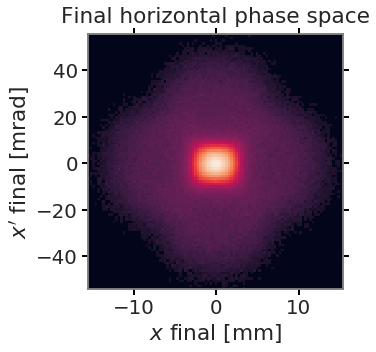

In [93]:
plt.figure(figsize=(6, 5))
plt.hist2d(pyht_beam.x*1e3, pyht_beam.xp*1e3, bins=100, norm=mcolors.PowerNorm(0.3))
plt.xlabel('$x$ final [mm]')
plt.ylabel('$x\'$ final [mrad]')
plt.title('Final horizontal phase space', y=1.02)
plt.gca().set_aspect(np.diff(plt.xlim()) / np.diff(plt.ylim()))
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_bunch.png', dpi=150, bbox_inches='tight')

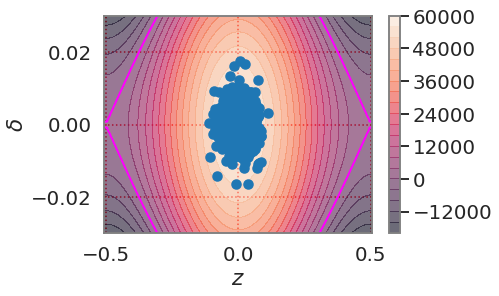

In [94]:
rfb = RFBucket(circumference, gamma, m_p, e, [0], 0, [1], [rf_voltage], [np.pi])

z = np.linspace(*rfb.interval, num=100)
dp = np.linspace(-0.03, 0.03, num=100)
ZZ, DPP = np.meshgrid(z, dp)
HH = rfb.hamiltonian(ZZ, DPP, make_convex=True)
plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
plt.colorbar()
plt.contour(ZZ, DPP, HH, levels=[0], colors='magenta', linewidths=2)
plt.scatter(pyht_beam.z[::1000], pyht_beam.dp[::1000])
plt.xlabel(r'$z$')
plt.ylabel(r'$\delta$');

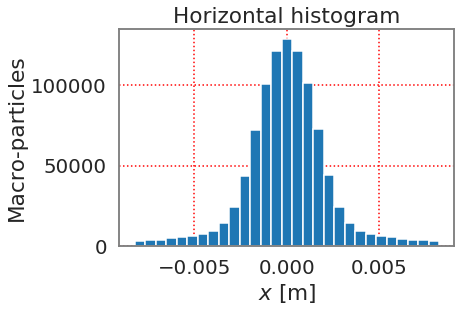

In [95]:
plt.hist(pyht_beam.x, bins=np.linspace(-pyht_beam.sigma_x()*3, pyht_beam.sigma_x()*3, 30));
plt.xlabel('$x$ [m]')
plt.ylabel('Macro-particles')
plt.title('Horizontal histogram');

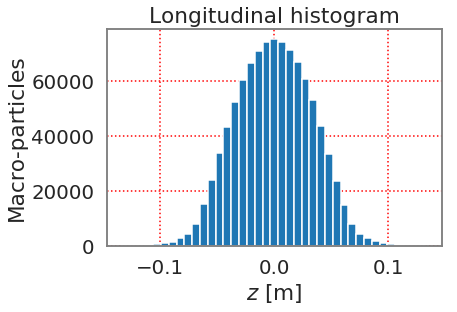

In [96]:
plt.hist(pyht_beam.z, bins=np.linspace(-pyht_beam.sigma_z()*4, pyht_beam.sigma_z()*4, 40));
plt.xlabel('$z$ [m]')
plt.ylabel('Macro-particles')
plt.title('Longitudinal histogram');

In [97]:
assert all([all(pyht_beam.x), all(pyht_beam.xp), all(pyht_beam.y), all(pyht_beam.yp), all(pyht_beam.z)])

# Tune Footprint

In [98]:
import PyNAFF as pnf
sys.path.append(os.path.dirname(os.path.abspath('.')))
from tune_diagram import ResonanceLines

In [99]:
def get_tune(signal_128_turns):
    return pnf.naff(signal_128_turns, 128, 1, 0 , False, window=1)[0,1]

In [100]:
qx_i = np.array([get_tune(i) for i in rec_inc_x[-128:].T])
qy_i = np.array([get_tune(i) for i in rec_inc_y[-128:].T])

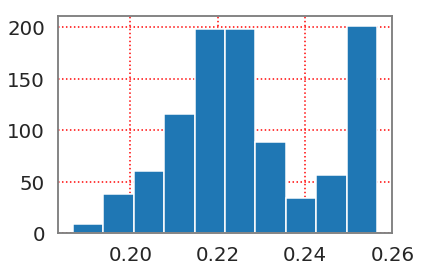

In [101]:
plt.hist(qx_i);

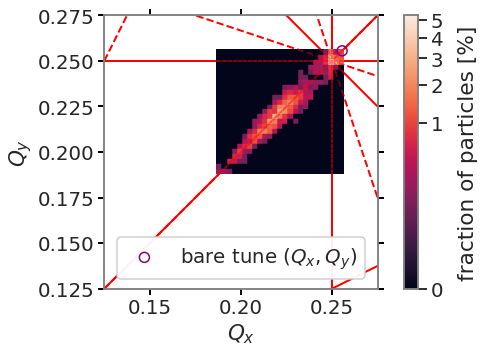

In [102]:
fig = plt.figure(figsize=(8,5)) 

extent_x = (np.floor(Qx) + 0.475 - 0.35, np.ceil(Qx) + 0.025 - 0.25 - 0.5)
extent_y = (np.floor(Qy) + 0.475 - 0.35, np.ceil(Qy) + 0.025 - 0.25 - 0.5)

resonances = ResonanceLines(extent_x, 
                            extent_y,
                            range(1, 4+1), 1)
resonances.plot_resonance(fig)
plt.gca().set_aspect('equal')

inc_tunes_x = np.abs(qx_i)
inc_tunes_y = np.abs(qy_i)

plt.hist2d(inc_tunes_x, inc_tunes_y, bins=25,
           zorder=12, alpha=0.5, 
           weights=np.ones_like(inc_tunes_x)/len(inc_tunes_x)*100,
           norm=mcolors.PowerNorm(0.3))
plt.hist2d(inc_tunes_x, inc_tunes_y, bins=25, 
           weights=np.ones_like(inc_tunes_x)/len(inc_tunes_x)*100,
           norm=mcolors.PowerNorm(0.3))
cbar = plt.colorbar()
cbar.set_label('fraction of particles [%]', labelpad=15)

plt.xlim(extent_x)
plt.ylim(extent_y)

plt.scatter(Qx, Qy, color='purple', marker='o', facecolor='None', 
            linestyle='None', s=100, zorder=13, label=r"bare tune $(Q_x,Q_y)$")
plt.legend(loc=8, framealpha=0.95)

plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)

plt.tight_layout()
plt.savefig('FODO_syncmot64_with_3DPIC_8e6mp_SC_tunespread.png', dpi=150, bbox_inches='tight')